# Porosity analysis, connected components

Continuation of the segmentation notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import tifffile
import skimage.filters
import skimage.measure
import scipy
import os


def mixed_colors(N, bg=0.5, bg_alpha=0.5):
    '''Colormap with permuted jet colors.'''
    rng = np.random.default_rng(2022)
    colors = plt.cm.jet(np.linspace(0, 1, N))
    colors = rng.permutation(colors)
    colors = np.vstack((np.array([bg] * 3 + [bg_alpha]), colors))
    cmap = matplotlib.colors.ListedColormap(colors)
    return cmap


In [2]:
# Get data, if needed
if not os.path.isfile('hourglass_temp_vol.tiff'):
    !wget -q https://qim.compute.dtu.dk/data-repository/hourglass_temp.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('hourglass_temp.zip')

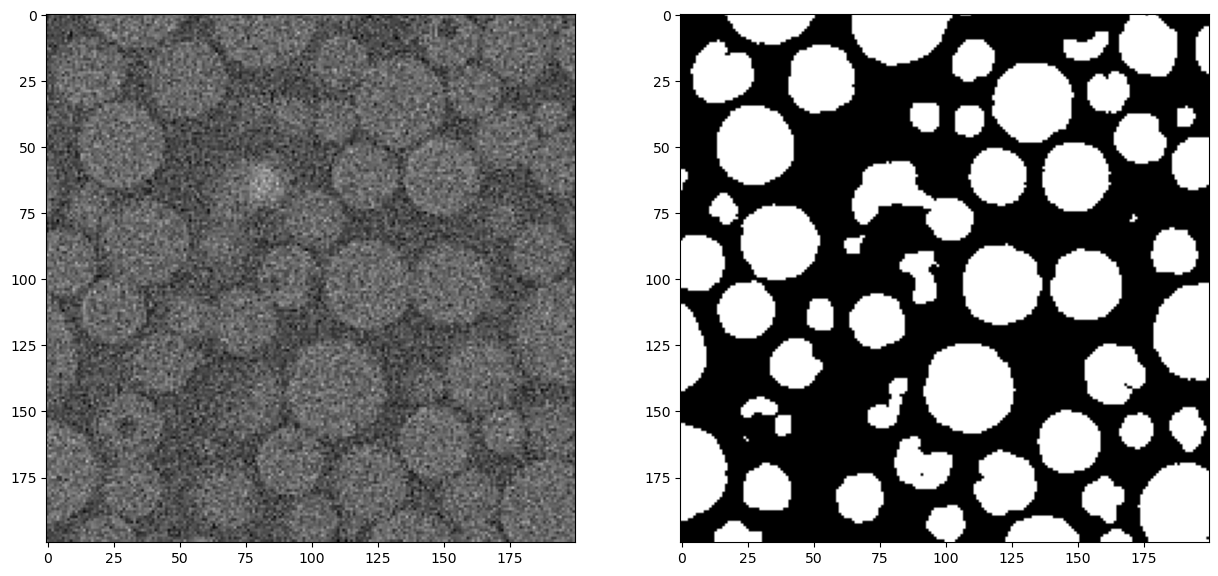

In [3]:
# Load segmentation results
vol = tifffile.imread('hourglass_temp_vol.tiff')
bin_vol = tifffile.imread('hourglass_temp_bin_vol.tiff').astype(bool)
Z, Y, X = vol.shape

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(vol[Z//2], vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
plt.show()



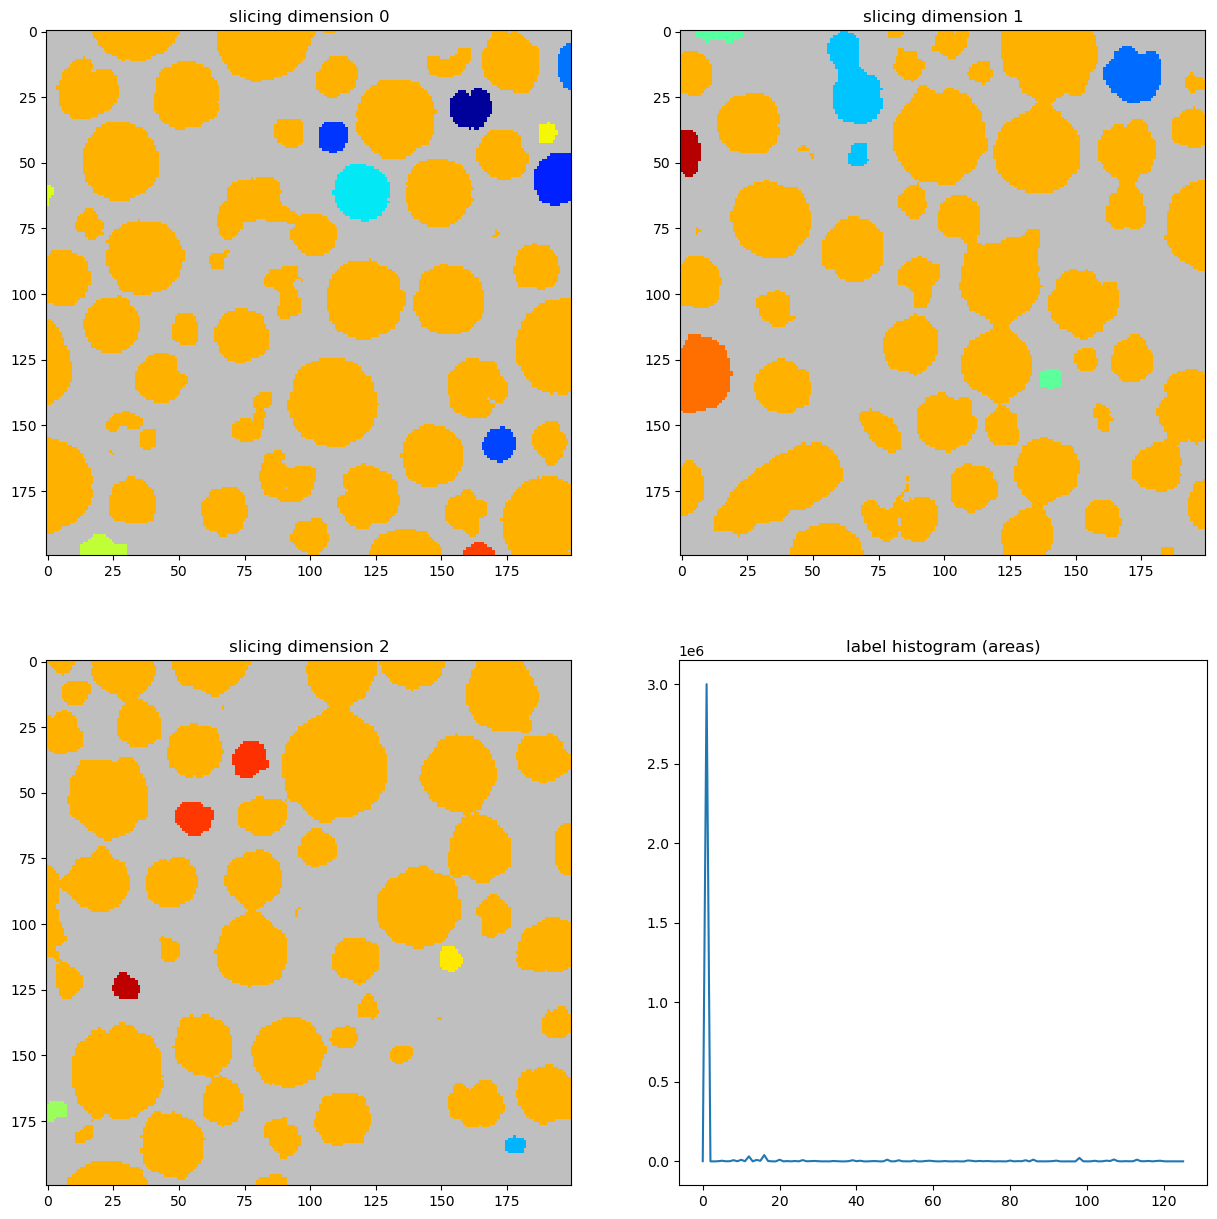

In [4]:
# Try connected component analysis.

labels = skimage.measure.label(bin_vol)  # objects need to be True in binary volume
nr_cc = labels.max()
cmap = mixed_colors(nr_cc)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

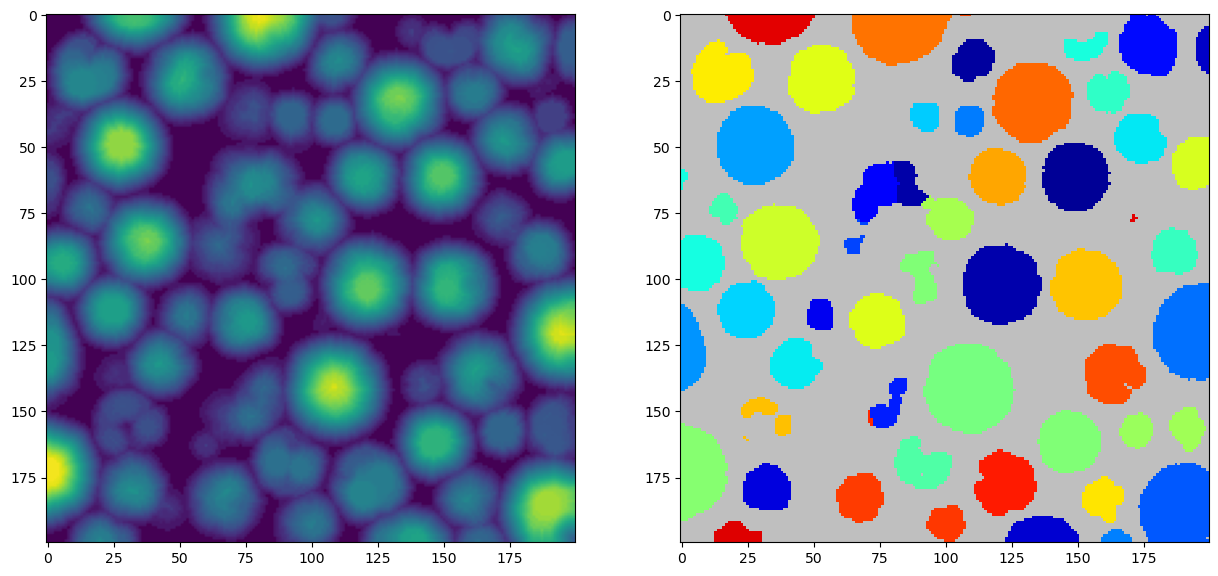

In [5]:
# Perform watershed transform to separate pores.

distance_field = scipy.ndimage.distance_transform_edt(bin_vol)
distance_field = skimage.morphology.dilation(distance_field, skimage.morphology.ball(5))
labels = skimage.segmentation.watershed(-distance_field, mask=bin_vol)

nr_cc = labels.max()
cmap = mixed_colors(nr_cc)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(distance_field[Z//2])
ax[1].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')

plt.show()


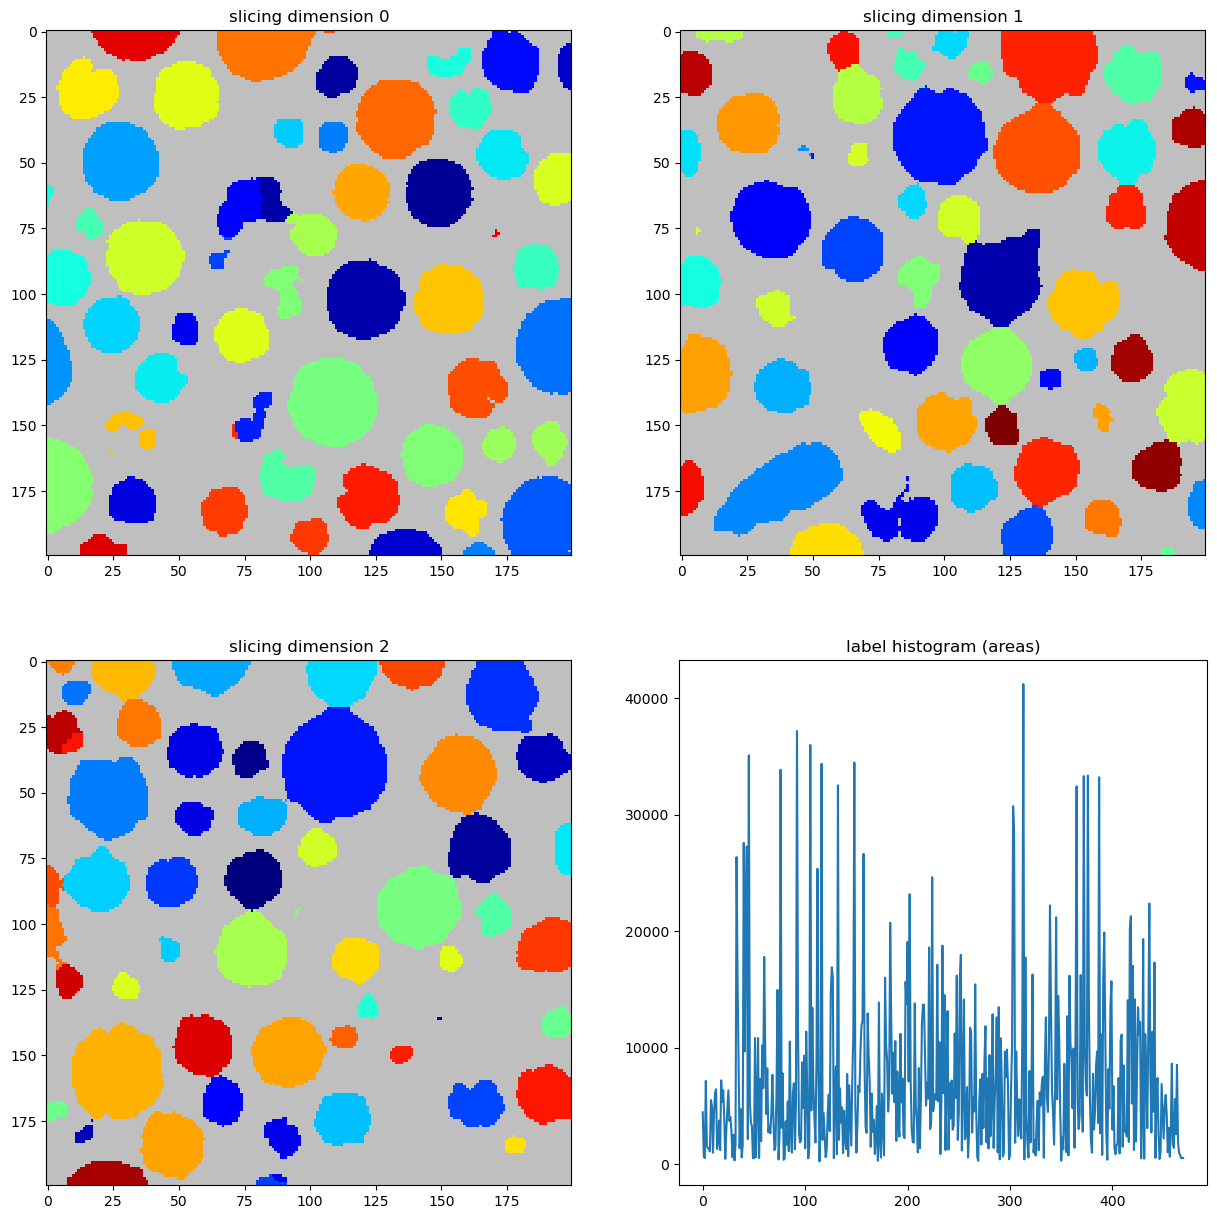

In [6]:
# Visualize output of connected component analysis on orhogonal slices.

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

In [7]:
# Collect some statistics about connected components.

props = skimage.measure.regionprops(labels)
areas = [props[i].area for i in range(nr_cc)]
print(max(areas))


41198


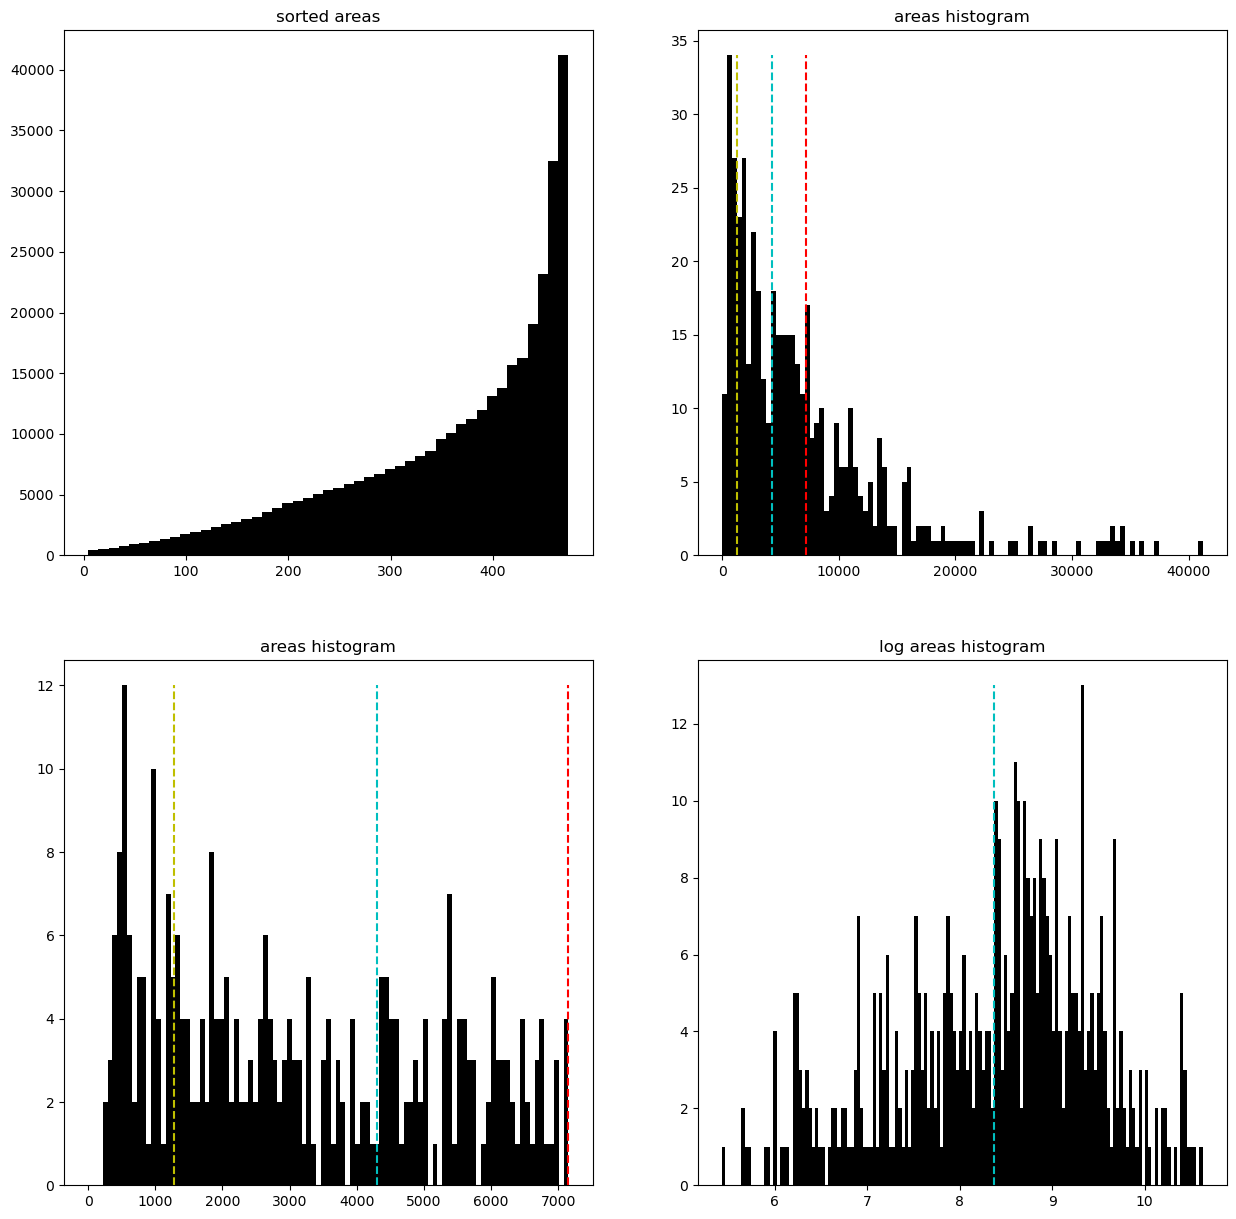

In [8]:
# Visualize the statistics.

areas = np.asanyarray(areas)
area_mean = areas.mean()
logareas = np.log(areas)
area_median = np.exp(logareas.mean())
area_mode = np.exp(logareas.mean() - logareas.std()**2) 

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

ax[0].bar(np.arange(len(areas))[len(areas):0:-10], 
          np.sort(areas)[len(areas):0:-10], width=10, color='k')
ax[0].set_title('sorted areas')

edges = np.linspace(0, areas.max(), 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[1].bar(centers, hist, width=width, color='k')
ax[1].set_title('areas histogram')
ax[1].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[1].plot([area_median]*2, [0, hist.max()], 'c--')
ax[1].plot([area_mode]*2, [0, hist.max()], 'y--')

edges = np.linspace(0, area_mean, 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[2].bar(centers, hist, width=width, color='k')
ax[2].set_title('areas histogram')
ax[2].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[2].plot([area_median]*2, [0, hist.max()], 'c--')
ax[2].plot([area_mode]*2, [0, hist.max()], 'y--')

hist, edges = np.histogram(logareas, 150)
centers = 0.5*(edges[:-1] + edges[1:])
width = centers[1] - centers[0]
ax[3].bar(centers, hist, width=width, color='k')
ax[3].plot([logareas.mean()]*2, [0, hist.max()], 'c--')
ax[3].set_title('log areas histogram')
plt.show()


In [9]:
# Print summary.

print(f'Voxels per porosity {bin_vol.size/nr_cc:.0f}.')
print(f'Material density {100*bin_vol.sum()/bin_vol.size:.0f}%.')
print(f'Porosity area mean, median and mode {area_mean:.0f}, {area_median:.0f}, {area_mode:.0f}.')


Voxels per porosity 17021.
Material density 42%.
Porosity area mean, median and mode 7150, 4301, 1279.


In [18]:
def save_cc_for_paraview(labels, filename_root, factor=5, pad=True):
    '''Saves results of connected component analysis in several volumes suitable
    for visualization in paraview.
    Inputs:
        labels: label volume,  a 3D numpy array of integers, where 0 is 
            bacground and 1 to N are connected components.
        filename_root: root of the filename, sufixes will be added 
        factor: int, downscaling factor.
        pad: bool, whether to pad with background to ensure closed surfaces.
    '''
    
    Z, Y, X = labels.shape
 
    labels = labels[Z%factor//2::factor, Y%factor//2::factor, X%factor//2::factor]
    if pad:
        labels = np.pad(labels, ((1, 1), ) * 3, constant_values=0)

    cmap = mixed_colors(labels.max(), bg=1, bg_alpha=0.1)  # white blends nicer
    
    with (tifffile.TiffWriter(filename_root + '_binary.tif') as binary, 
            tifffile.TiffWriter(filename_root + '_rgba.tif') as rgba, 
            tifffile.TiffWriter(filename_root + '_rgb.tif') as rgb):
        for l in labels:
            binary.write((255 * (l>0)).astype(np.uint8))
            l_rgba = cmap(l)
            l_rgba[:, :, 3] = 1 - l_rgba[:, :, 3]  # flipping opacity to work with paraview
            rgba.write((255*l_rgba).astype(np.uint8), photometric='rgb', extrasamples = 'ASSOCALPHA') 
            rgb.write((255*l_rgba[:, :, :3]).astype(np.uint8), photometric='rgb')
    

save_cc_for_paraview(labels, 'porosity_hourglass/cc_results')

    
